In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_idx_sig = f["jet_ttbar_match"].array()
    jet_label_sig = ak.ones_like(jet_pt_sig)

# Load background sample into memory
with uproot.open("ntuples/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_idx_bkg = f["jet_ttbar_match"].array()
    jet_label_bkg = ak.zeros_like(jet_pt_bkg)

In [3]:
# crazy vectorized syntax https://awkward-array.org/doc/main/user-guide/how-to-restructure-concatenate.html#emulating-numpy-s-stack-functions
jet_sig = ak.concatenate([jet_pt_sig[:, np.newaxis], jet_eta_sig[:, np.newaxis], jet_phi_sig[:, np.newaxis], jet_m_sig[:, np.newaxis], jet_pufr_sig[:, np.newaxis], jet_label_sig[:, np.newaxis]], axis=1)
jet_bkg = ak.concatenate([jet_pt_bkg[:, np.newaxis], jet_eta_bkg[:, np.newaxis], jet_phi_bkg[:, np.newaxis], jet_m_bkg[:, np.newaxis], jet_pufr_bkg[:, np.newaxis], jet_label_bkg[:, np.newaxis]], axis=1)

# combine sig and bkg into one vector
jet_feats = ak.concatenate([jet_sig, jet_bkg], axis=0)
jet_idx = np.array(ak.concatenate([jet_idx_sig, jet_idx_bkg], axis=0))

In [4]:
%%time
# Find the selected jets and append their features to a list
num_events = len(jet_feats)
jet_list = []
for event in range(num_events):
    if (len(np.unique(jet_idx[event])) != 6):
        continue
    idx = jet_idx[event]
    jet_list_tmp = []
    for i, jet in enumerate(idx):
        jet_list_tmp.append(np.array(jet_feats[event,:,jet]))
    jet_list.append(np.array(jet_list_tmp))

# Shuffle the list and convert to np.array()
random.shuffle(jet_list)
data = np.array(jet_list)
print(data.shape)

(7494, 6, 6)
CPU times: user 7.63 s, sys: 3.07 ms, total: 7.63 s
Wall time: 7.63 s


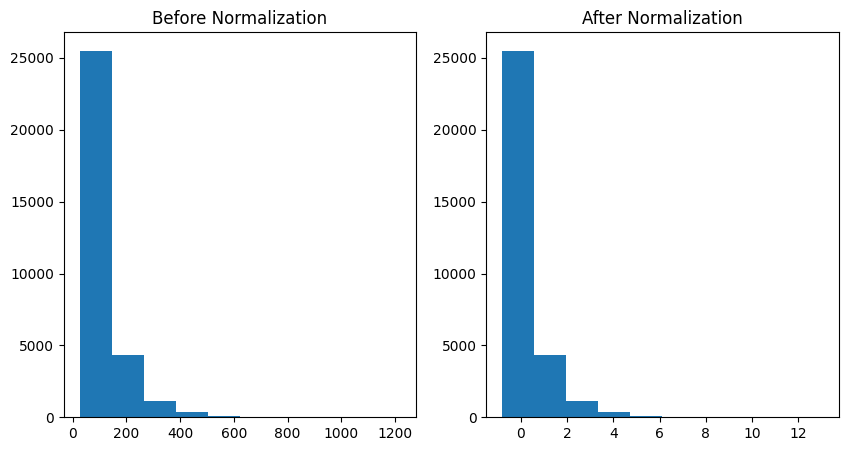

Before Mean:  94.103905
Before STD:  86.17673
After Mean:  -9.740994e-07
After STD:  1.0000014


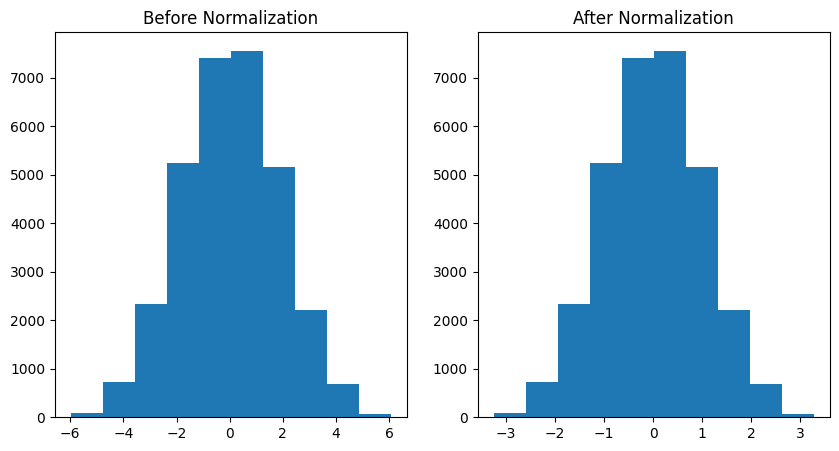

Before Mean:  0.028747404
Before STD:  1.8433361
After Mean:  -4.9638338e-08
After STD:  1.0000014


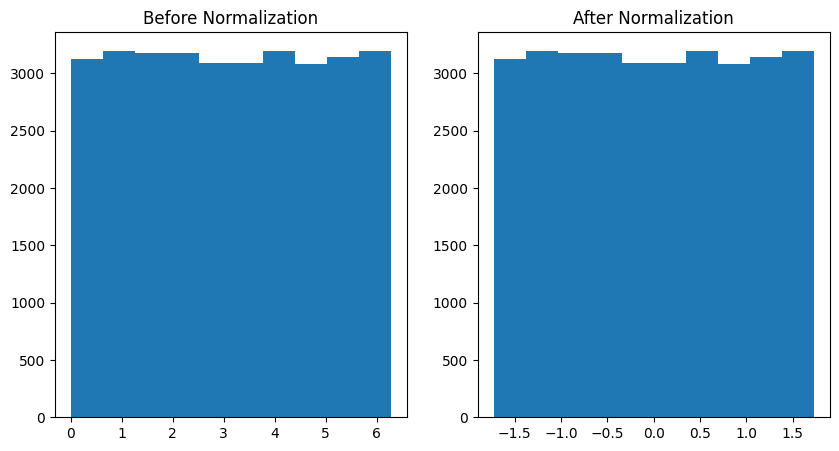

Before Mean:  3.1396337
Before STD:  1.8172365
After Mean:  2.816718e-06
After STD:  1.000002


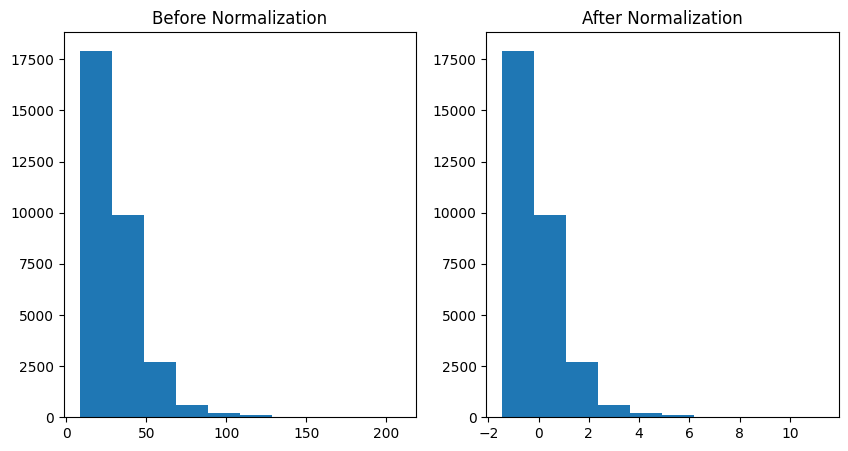

Before Mean:  30.958456
Before STD:  15.707717
After Mean:  -4.8708607e-06
After STD:  0.99999857


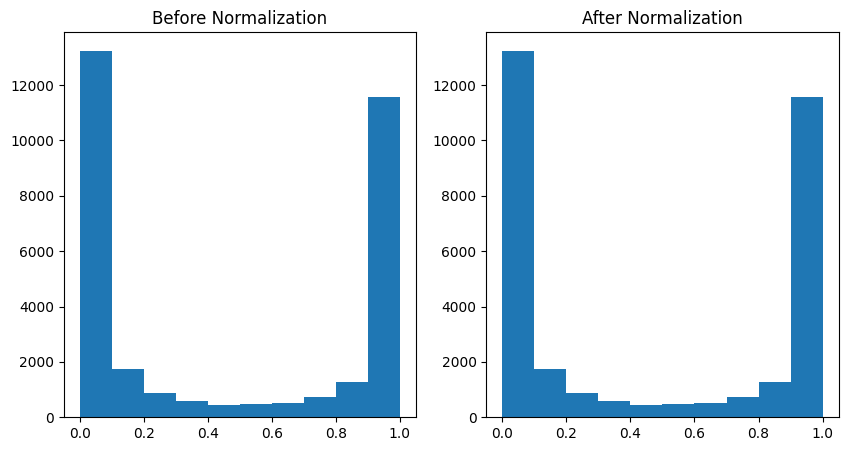

Before Mean:  0.4710133
Before STD:  0.44441524
After Mean:  0.4710133
After STD:  0.44441524


In [5]:
# Split dataset into train, val, test split
num_events = len(data)
X_train_raw = data[0:int(0.7*num_events)][:,:,0:5]
y_train = data[0:int(0.7*num_events)][:,:,5].mean(axis=1).reshape(-1,1)
X_val_raw = data[int(0.7*num_events):int(0.75*num_events)][:,:,0:5]
y_val = data[int(0.7*num_events):int(0.75*num_events)][:,:,5].mean(axis=1).reshape(-1,1)
X_test_raw = data[int(0.75*num_events):][:,:,0:5]
y_test = data[int(0.75*num_events):][:,:,5].mean(axis=1).reshape(-1,1)

# Calculate the mean and std of each feature
X_train_means = np.mean(X_train_raw.reshape(-1,5),0)
X_train_stds = np.std(X_train_raw.reshape(-1,5),0)
# Do not apply mean and std to pufr
X_train_means[-1]=0
X_train_stds[-1]=1

# Normalize dataset
X_train_norm = np.divide(np.subtract(X_train_raw,X_train_means),X_train_stds)
X_val_norm = np.divide(np.subtract(X_val_raw,X_train_means),X_train_stds)
X_test_norm = np.divide(np.subtract(X_test_raw,X_train_means),X_train_stds)

# Validation plots
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = X_train_raw[:,:,i].flatten()
    ax1.hist(var1)
    ax1.set_title("Before Normalization")
    var2 = X_train_norm[:,:,i].flatten()
    ax2.hist(var2)
    ax2.set_title("After Normalization")
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train = torch.Tensor(X_train_norm)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val_norm)
y_val = torch.Tensor(y_val)
X_test = torch.Tensor(X_test_norm)
y_test = torch.Tensor(y_test)

In [6]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_postprocess = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        jet_embedding = F.gelu(self.jet_preprocess(jet_feats))
        jet_aggregated = jet_embedding.sum(dim=1)
        output = F.sigmoid(self.jet_postprocess(jet_aggregated))
        return output

In [7]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}

    for e in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train.to(device))
        loss = loss_fn(outputs, y_train.to(device))
        loss.backward()
        optimizer.step()

        model.eval()
        history['train_loss'].append(loss.detach().cpu().numpy())
        y_pred = model(X_val.to(device))
        test_loss = loss_fn(y_pred,y_val.to(device)).detach().cpu().numpy()
        history['test_loss'].append(test_loss)
        if (e+1)%100==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history   

In [8]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  False
cpu


Training Baseline
Epoch: 100 	Train Loss: 0.6033 	Test Loss: 0.6146
Epoch: 200 	Train Loss: 0.573 	Test Loss: 0.5886
Epoch: 300 	Train Loss: 0.5616 	Test Loss: 0.5793
Epoch: 400 	Train Loss: 0.5564 	Test Loss: 0.5752
Epoch: 500 	Train Loss: 0.5533 	Test Loss: 0.5727
Epoch: 600 	Train Loss: 0.5512 	Test Loss: 0.5707
Epoch: 700 	Train Loss: 0.5497 	Test Loss: 0.5691
Epoch: 800 	Train Loss: 0.5487 	Test Loss: 0.5679
Epoch: 900 	Train Loss: 0.548 	Test Loss: 0.5669
Epoch: 1000 	Train Loss: 0.5475 	Test Loss: 0.5662

Training Model
Epoch: 100 	Train Loss: 0.6158 	Test Loss: 0.6216
Epoch: 200 	Train Loss: 0.5756 	Test Loss: 0.5854
Epoch: 300 	Train Loss: 0.5601 	Test Loss: 0.5719
Epoch: 400 	Train Loss: 0.5523 	Test Loss: 0.5656
Epoch: 500 	Train Loss: 0.5481 	Test Loss: 0.5624
Epoch: 600 	Train Loss: 0.5458 	Test Loss: 0.5609
Epoch: 700 	Train Loss: 0.5445 	Test Loss: 0.5603
Epoch: 800 	Train Loss: 0.5437 	Test Loss: 0.5601
Epoch: 900 	Train Loss: 0.5433 	Test Loss: 0.5601
Epoch: 1000 	Trai

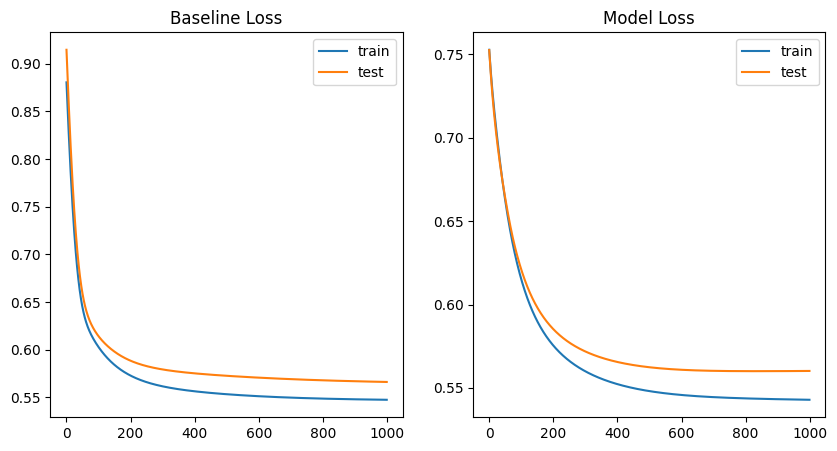

In [9]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

# Train baseline model with pt,eta,phi,m
print("Training Baseline")
baseline = Model(4,256,1).to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.00008)
data = [X_train[:,:,0:4], y_train, X_val[:,:,0:4], y_val]
baseline_history = train(baseline, data, epochs=1000)
print()

# Train upgraded model with pt,eta,phi,m,pufr
print("Training Model")
model = Model(5,256,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00008)
data = [X_train, y_train, X_val, y_val]
model_history = train(model, data, epochs=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_loss'],label='train')
ax1.plot(baseline_history['test_loss'],label='test')
ax1.set_title("Baseline Loss")
ax1.legend()
ax2.plot(model_history['train_loss'],label='train')
ax2.plot(model_history['test_loss'],label='test')
ax2.set_title("Model Loss")
ax2.legend()
plt.show()

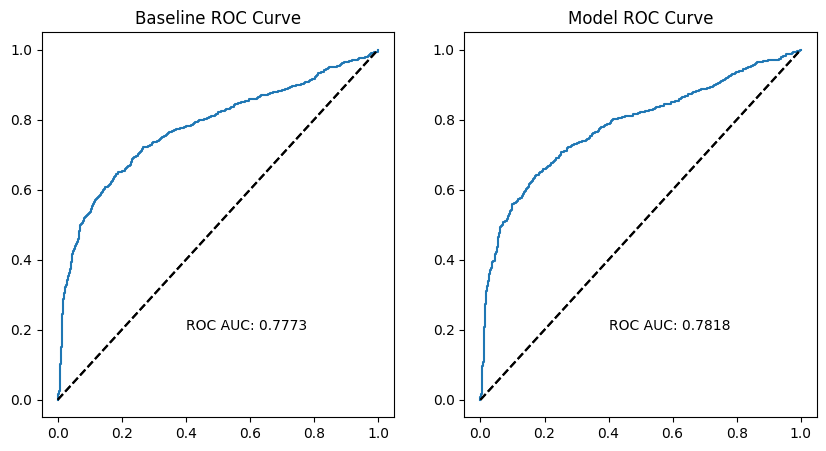

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
                             
baseline.to('cpu')
y_pred = baseline(X_test[:,:,0:4]).detach()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax1.plot(fpr,tpr)
ax1.plot([[0,0],[1,1]],'--',color='k')
ax1.set_title("Baseline ROC Curve")
AUC = "ROC AUC: " + str(round(roc_auc_score(y_test, y_pred),4))
ax1.text(0.4,0.2,AUC)

model.to('cpu')
y_pred = model(X_test).detach()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax2.plot(fpr,tpr)
ax2.plot([[0,0],[1,1]],'--',color='k')
ax2.set_title("Model ROC Curve")
AUC = "ROC AUC: " + str(round(roc_auc_score(y_test, y_pred),4))
ax2.text(0.4,0.2,AUC)
plt.show()